In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# Get the required files
df_sig = pd.read_hdf('Honly_sig_NN_var.h5', 'df_sig')
df_bkg2 = pd.read_hdf('qqZZ_bkg_NN_var.h5','df_bkg2')
#get 1 jet events
df_sig1j = df_sig[df_sig['n_jets']==1]
df_bkg21j = df_bkg2[df_bkg2['n_jets']==1]

In [3]:
# names of event-level branches
npart = ["ggZZ_ME_0j","ggHZZ_ME_0j","qqZZ_ME_0j","m4l_unconstrained","cos_theta_str","cos_theta_1","pt4l_fsr","phi","phi_1","Z1_m","Z2_m","n_jets"]

In [4]:
df= pd.concat((df_sig[npart], df_bkg2[npart]), ignore_index=True)
#df.head()

In [5]:
X = df.as_matrix()

/opt/rh/rh-python36/root/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [6]:
w =  pd.concat((df_sig['weight'], df_bkg2['weight']), ignore_index=True).values

In [7]:
type(w)

numpy.ndarray

In [8]:
y = []
for _df, ID in [(df_sig, 0), (df_bkg2, 1)]:
    y.extend([ID] * _df.shape[0])
y = np.array(y)

In [9]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [10]:
ix = range(X.shape[0])
X_train, X_test, y_train, y_test, w_train, w_test, ix_train, ix_test = train_test_split(X, y, w, ix, train_size=0.6)

/opt/rh/rh-python36/root/usr/lib64/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
from keras.models import Model
from keras.layers import Dense, Dropout, Input

In [13]:
inputs = Input(shape=(X_train.shape[1], )) # placeholder

hidden = Dense(10, activation='relu')(inputs)
hidden = Dropout(0.2)(hidden)
#hidden = Dense(20, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
#hidden = Dense(30, activation='relu')(hidden)
#hidden = Dropout(0.2)(hidden)
outputs = Dense(2, activation='softmax')(hidden)
# last layer has to have the same dimensionality as the number of classes we want to predict, here 3

model = Model(inputs, outputs)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                130       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 22        
Total params: 152
Trainable params: 152
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model, 'temp.png', show_shapes=True)

In [16]:
model.compile('adam', 'sparse_categorical_crossentropy')

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [18]:
from collections import Counter
Counter(y_test)

Counter({1: 4623, 0: 4520})

In [19]:
print ('Training:')
try:
    model.fit(
        X_train, y_train, class_weight={ # rebalance class representation
            0 : 0.50 * (float(len(y)) / (y == 0).sum()),
            1 : 0.50 * (float(len(y)) / (y == 1).sum()),
            #2 : 0.40 * (float(len(y)) / (y == 2).sum())
        },
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('./tutorial-progress.h5', monitor='val_loss', verbose=True, save_best_only=True)
        ],
        epochs=20, 
        validation_split = 0.2,
        verbose=True ) 
except KeyboardInterrupt:
    print('Training ended early.')

Training:
Instructions for updating:
Use tf.cast instead.
Train on 10970 samples, validate on 2743 samples
Epoch 1/20
10970/10970 [==============================] - 1s 75us/step - loss: 0.6376 - val_loss: 0.5749

Epoch 00001: val_loss improved from inf to 0.57490, saving model to ./tutorial-progress.h5
Epoch 2/20
10970/10970 [==============================] - 1s 52us/step - loss: 0.5910 - val_loss: 0.5550

Epoch 00002: val_loss improved from 0.57490 to 0.55499, saving model to ./tutorial-progress.h5
Epoch 3/20
10970/10970 [==============================] - 1s 53us/step - loss: 0.5753 - val_loss: 0.5448

Epoch 00003: val_loss improved from 0.55499 to 0.54477, saving model to ./tutorial-progress.h5
Epoch 4/20
10970/10970 [==============================] - 1s 52us/step - loss: 0.5642 - val_loss: 0.5376

Epoch 00004: val_loss improved from 0.54477 to 0.53757, saving model to ./tutorial-progress.h5
Epoch 5/20
10970/10970 [==============================] - 0s 42us/step - loss: 0.5605 - val_l

In [20]:
# -- load in best network
model.load_weights('./tutorial-progress.h5')

# -- Save network weights and structure
print( 'Saving model...')
model.save_weights('./tutorial.h5', overwrite=True)
json_string = model.to_json()
open('./tutorial.json', 'w').write(json_string)
print ('Done')

Saving model...
Done


In [21]:
print ('Testing...')
yhat = model.predict(X_test, verbose = True, batch_size = 512)

Testing...
9143/9143 [==============================] - 0s 4us/step


In [22]:
yhat

array([[0.22121365, 0.7787863 ],
       [0.22084889, 0.7791512 ],
       [0.7569541 , 0.24304593],
       ...,
       [0.61629826, 0.38370177],
       [0.5333759 , 0.46662405],
       [0.33976948, 0.6602305 ]], dtype=float32)

In [23]:
#yhat_cls = np.argmax(yhat, axis=1)
yhat_cls = np.argmax(yhat>0.6, axis=1)

In [24]:
yhat_cls

array([1, 1, 0, ..., 0, 0, 1])

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
cnf_matrix = confusion_matrix(y_test, yhat_cls, sample_weight=w_test)
np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.81 0.19]
 [0.07 0.93]]


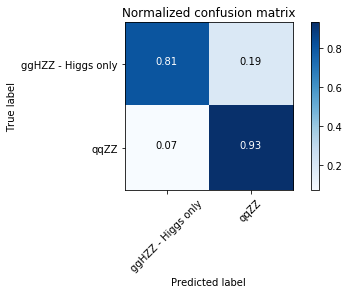

In [27]:
plot_confusion_matrix(cnf_matrix, classes=['ggHZZ - Higgs only', 'qqZZ'],
                      normalize=True,
                      title='Normalized confusion matrix')

In [28]:
# signal eff = weighted tpr --> out of all signal events, what % for we classify as signal?
print ('Signal efficiency:', w_test[(y_test == 0) & (yhat_cls == 0)].sum() / w_test[y_test == 0].sum())

# bkg eff = weighted fpr --> out of all bkg events, what % do we classify as signal?
b_eff = w_test[(y_test != 0) & (yhat_cls == 0)].sum() / w_test[y_test != 0].sum()
print ('Background efficiency:', b_eff )
print ('Background rej:', 1 / b_eff)

Signal efficiency: 0.8076135347296567
Background efficiency: 0.06809336842751892
Background rej: 14.685717906060656
